feature output: dssp, rigidity

In [10]:
## output dssp (RSA) for each amino acid  ##
from RUN_FIRST import pdb_clean
from output_dssp import output_dssp
import pandas as pd
import os
import warnings

warnings.filterwarnings("ignore")

root_dir = '/Users/liyao/Desktop/Tsuda_Lab/Source_code/AI-HDX-main/HDX_MS_dataset/database_collection/feature'
pdb_dir = f'{root_dir}/structure'
dssp_dir = f'{root_dir}/dssp_files'
if os.path.isdir(dssp_dir) == False:
    os.mkdir(dssp_dir)

fname = 'merged_apo.xlsx'
apo_df = pd.read_excel(f'{root_dir}/../{fname}', sheet_name='Sheet1')
apo_df = apo_df.dropna(subset=['chain_identifier'])
fail_list = []

for index, row in apo_df.iterrows():
    pdb_fname = row['apo_identifier'].strip().split('.')[0]
    chain_id = row['chain_identifier'].strip()
    uni_id = row['match_uni'].strip()
    
    print('start processing', f'{pdb_fname}_{chain_id}')        
    if os.path.isfile(f'{root_dir}/dssp_files/{pdb_fname}_{chain_id}.dssp.txt'):
        continue
    if os.path.isfile(f'{root_dir}/structure/{uni_id}/{pdb_fname}.pdb'):
        try:
            pdb_clean(f'{root_dir}/structure/{uni_id}/{pdb_fname}.pdb', f'{root_dir}/structure/{uni_id}/{pdb_fname}_clean.pdb')
            output_dssp(f'{pdb_fname}_{chain_id}', f'{root_dir}/structure/{uni_id}/{pdb_fname}_clean.pdb', chain_id, f'{root_dir}/dssp_files')
        except Exception as e:
            fail_list.append(pdb_fname)
            print(e)
            continue
    else:
        print(f'{root_dir}/structure/{uni_id}/{pdb_fname}.pdb does not exist')
print(fail_list)

start processing AF_TRAPP_1+3+4+6a_revised_B
output_dssp() takes 3 positional arguments but 4 were given
['AF_TRAPP_1+3+4+6a_revised']


In [ ]:
### output fasta file for hhblits ###
from predataprocess import get_pdb_seq
from Bio import PDB

root_dir = '/Users/liyao/Desktop/Tsuda_Lab/Source_code/AI-HDX-main/HDX_MS_dataset/database_collection/feature'
fname = 'merged_apo.xlsx'
apo_df = pd.read_excel(f'{root_dir}/../{fname}', sheet_name='Sheet1')
apo_df = apo_df.dropna(subset=['chain_identifier'])
fail_list = []

for index, row in apo_df.iterrows():
    pdb_fname = row['apo_identifier'].strip().split('.')[0]
    chain_id = row['chain_identifier'].strip()
    uni_id = row['match_uni'].strip()
    print('start processing', f'{pdb_fname}_{chain_id}')        
    if os.path.isfile(f'{root_dir}/structure/{uni_id}/{pdb_fname}.pdb'):
        try:
            parser = PDB.PDBParser()
            filepath = f'{root_dir}/structure/{uni_id}/{pdb_fname}.pdb'
            structure = parser.get_structure('AF_structure', filepath)
            sequence, residue_indices = get_pdb_seq(structure, chain_id)
            if os.path.isdir(f'{root_dir}/fasta_files') == False:
                os.mkdir(f'{root_dir}/fasta_files')
            with open(f'{root_dir}/fasta_files/{pdb_fname}_{chain_id}.fasta', 'w') as f:
                f.write(f'>{pdb_fname}_{chain_id}\n')
                f.write(sequence)
        except Exception as e:
            print(e)
            fail_list.append(pdb_fname+'_'+chain_id)
            continue
    else:
        print(f'{root_dir}/structure/{uni_id}/{pdb_fname}.pdb does not exist')
print(fail_list)

In [ ]:
### secondary structure one-hot encoding ###
root_dir = '/Users/liyao/Desktop/Tsuda_Lab/Source_code/AI-HDX-main/HDX_MS_dataset/database_collection/feature/'
dssp_dir = f'{root_dir}/dssp_files'

def one_of_k_encoding(x, allowable_set):
    if x not in allowable_set:
        raise Exception("input {0} not in allowable set{1}:".format(x, allowable_set))
    return [int(x == s) for s in allowable_set]

folder_list = os.listdir(dssp_dir)
for folder in folder_list:
    if folder == '.DS_Store':
        continue

    dssp_file = f'{dssp_dir}/{folder}'
    with open(dssp_file, 'r') as f:
        for line in f:
            content = line.split()
            dssp_value = round(float(content[3]), 4)
            ss_type = content[2]
            ss_list = ['H', 'B', 'E', 'G', 'I', 'T', 'S', 'P', '-']
            ss_encoding = one_of_k_encoding(ss_type, ss_list)
            print(ss_type)
            print(ss_encoding)


In [ ]:
### add H to pdb file, then run FIRST ###
import os
import shutil
from RUN_FIRST import RUN_FIRST, copyfiles, pdb_clean, hbplus

root_dir = '/Users/liyao/Desktop/Tsuda_Lab/Source_code/AI-HDX-main/HDX_MS_dataset/database_collection/feature'
proflex_dir = f'/Users/liyao/Desktop/Tsuda_Lab/Source_code/ProFlex-master/proflex'
hbplus_dir = '/Users/liyao/Desktop/Tsuda_Lab/Source_code/hbplus'

pdb_dir = f'{root_dir}/structure'
save_dir = f'{root_dir}/proflex_files'

if os.path.isdir(save_dir) == False:
    os.mkdir(save_dir)

fname = 'merged_apo.xlsx'
apo_df = pd.read_excel(f'{root_dir}/../{fname}', sheet_name='Sheet1')
apo_df = apo_df.dropna(subset=['chain_identifier'])

for index, row in apo_df.iterrows():
    pdb_fname = row['apo_identifier'].strip().split('.')[0]
    chain_id = row['chain_identifier'].strip()
    uni_id = row['match_uni'].strip()

    pdb_fpath = f'{root_dir}/structure/{uni_id}/{pdb_fname}.pdb'

    proflex_name = f'{pdb_fname}_clean_Hplus_proflexdataset'
    if os.path.isfile(f'{save_dir}/{proflex_name}'):
        continue           
    
    if os.path.isfile(pdb_fpath):
        try:
            print('start processing', f'{pdb_fname}_{chain_id}') 
            pdb_folder = f'{root_dir}/structure/{uni_id}'
            if pdb_clean(pdb_fpath, f'{hbplus_dir}/{pdb_fname}_clean.pdb') == False:
                raise Exception('pdb_clean failed')
            hbplus(hbplus_dir, f'{pdb_fname}_clean', pdb_folder)

            pdb_fname = pdb_fname+'_clean_Hplus'       
            pdb_clean(f'{pdb_folder}/{pdb_fname}.pdb', f'{proflex_dir}/{pdb_fname}.pdb')
            RUN_FIRST(proflex_dir, f'{pdb_fname}.pdb', '-h')
            copyfiles(pdb_fname, proflex_dir, save_dir)

        except Exception as e:
            fail_list.append(pdb_fname)
            print(e)
            continue
print(fail_list)

In [ ]:
### add H to single pdb file ###
from RUN_FIRST import hbplus, pdb_clean

hbplus_dir = '/Users/liyao/Desktop/Tsuda_Lab/Source_code/hbplus/'
pdb_dir = f'/Users/liyao/Desktop/Tsuda_Lab/Source_code/AI-HDX-main/HDX_MS_dataset/database_collection/feature/structure/B5BTR7'
file = 'AF-B5BTR7-F1-model_v4.pdb'

pdb_clean(f'{pdb_dir}/{file}', f'{hbplus_dir}/{file}')
hbplus(hbplus_dir, file, pdb_dir)

In [ ]:
### convert proflex output to ASSURR flexibility index ###

from prot_rigidity import ASSURR_flexibility

proflex_dir = '/Users/liyao/Desktop/Tsuda_Lab/Source_code/AI-HDX-main/HDX_MS_dataset/database_collection/feature/proflex_files'
dssp_dir = '/Users/liyao/Desktop/Tsuda_Lab/Source_code/AI-HDX-main/HDX_MS_dataset/database_collection/feature/dssp_files'
save_dir = '/Users/liyao/Desktop/Tsuda_Lab/Source_code/AI-HDX-main/HDX_MS_dataset/database_collection/feature/rigidity_files'

ASSURR_flexibility(proflex_dir, dssp_dir, save_dir)

In [ ]:
import shutil
import os

root_dir = '/Users/liyao/Desktop/Tsuda_Lab/Source_code/AI-HDX-main/HDX_MS_dataset/database_collection/feature'
target_dir = f'{root_dir}/hhm_files'

os.chdir(target_dir)
folder_list = os.listdir(target_dir)
count = 0
for file in folder_list:
    if file == '.DS_Store':
        continue
    if ' ' in file:
        os.rename(file, file.replace(' ', ''))

    count += 1

print(count)

69


In [ ]:
import pandas as pd
import os

filepath = '/Users/liyao/Desktop/Tsuda_Lab/Source_code/AI-HDX-main/HDX_MS_dataset/database_collection/merged_apo.xlsx'
df = pd.read_excel(filepath, sheet_name='Sheet1')

print(df.shape)
df=df.drop_duplicates(subset=['match_uni'], keep='first')
print(df.shape)

match_uni_list = df['match_uni'].tolist()

for id in match_uni_list:
    id = id.strip()
    target_path = f'/Users/liyao/Desktop/Tsuda_Lab/Source_code/AI-HDX-main/HDX_MS_dataset/database_collection/feature/proflex_files/{id}_proflexdataset'
    if not os.path.isfile(target_path):
        print(id)
    pass


(84, 15)
(69, 15)
Q5F4T5


In [18]:
import pandas as pd
import os
from polyR_model import seq_embedding

def prepare_data():
    apo_df = pd.DataFrame()
    mutation_df = pd.DataFrame()
    apo_count = 0
    mutation_count = 0 
    root_dir = "/Users/liyao/Desktop/Tsuda_Lab/Source_code/AI-HDX-main/HDX_MS_dataset/database_collection"
    apo_path = f"{root_dir}/merged_apo.xlsx"
    apo_df = pd.read_excel(apo_path, sheet_name='Sheet1')
    apo_df = apo_df.dropna(subset=['chain_identifier'])

    manager_path = f"{root_dir}/manager.txt"
    manager = open(manager_path, 'r')
    manager.readline()
    available_list = []
    for line in manager:
        content = line.split(':')
        available_list.append(content[0])

    input_array = []
    truth_array = []
    error_id = []

    for index, row in apo_df.iterrows():
        identidier = row['database_id'].strip()
        if identidier not in available_list:
            continue
        uni_id = row['match_uni'].strip()
        state = row['state'].strip()
        apo_pdb = row['apo_identifier'].strip().split('.')[0]
        chain_id = row['chain_identifier'].strip()

        #print(identidier, uni_id, state)

        example_input = f"{root_dir}/{identidier}/apo_revised_modified.xlsx"
        mut_intput = f"{root_dir}/{identidier}/mutation_revised_modified.xlsx"
        example_embedding = f'{root_dir}/feature/embedding_files/{apo_pdb}_{chain_id}.embedding.txt'
        if os.path.isfile(example_embedding) == False or os.path.isfile(example_input) == False:
            print(example_embedding, example_input)
            continue
        
        if os.path.isfile(mut_intput):
            temp_apo_df = pd.read_excel(example_input, sheet_name='Sheet1')
            #temp_mutation_df = pd.read_excel(mut_intput, sheet_name='Sheet1')

            apo_df = pd.concat([apo_df, temp_apo_df], ignore_index=True)
            #mutation_df = pd.concat([mutation_df, temp_mutation_df], ignore_index=True)

        prot1, truth = seq_embedding(example_input, example_embedding, state)
        input_array.append(prot1)
        truth_array.extend(truth)

    #apo_df = apo_df.drop_duplicates(subset=['sequence'], keep='first')
    #mutation_df = mutation_df.drop_duplicates(subset=['sequence'], keep='first')
    #print(apo_df.shape[0], mutation_df.shape[0])
    return input_array, truth_array

## FIXME: currently can iterate through all the files, but there are many mismatch records ##
## FIXME: consider the exposure time, there are 20k pep apo sequences ##

/Users/liyao/Desktop/Tsuda_Lab/Source_code/AI-HDX-main/HDX_MS_dataset/database_collection/feature/embedding_files/4x06_A.embedding.txt /Users/liyao/Desktop/Tsuda_Lab/Source_code/AI-HDX-main/HDX_MS_dataset/database_collection/PXD011914/apo_revised_modified.xlsx
/Users/liyao/Desktop/Tsuda_Lab/Source_code/AI-HDX-main/HDX_MS_dataset/database_collection/feature/embedding_files/6h9v_A.embedding.txt /Users/liyao/Desktop/Tsuda_Lab/Source_code/AI-HDX-main/HDX_MS_dataset/database_collection/PXD011914/apo_revised_modified.xlsx
/Users/liyao/Desktop/Tsuda_Lab/Source_code/AI-HDX-main/HDX_MS_dataset/database_collection/feature/embedding_files/CSN_complex_B.embedding.txt /Users/liyao/Desktop/Tsuda_Lab/Source_code/AI-HDX-main/HDX_MS_dataset/database_collection/PXD013001/apo_revised_modified.xlsx
/Users/liyao/Desktop/Tsuda_Lab/Source_code/AI-HDX-main/HDX_MS_dataset/database_collection/feature/embedding_files/CSN_complex_D.embedding.txt /Users/liyao/Desktop/Tsuda_Lab/Source_code/AI-HDX-main/HDX_MS_datase

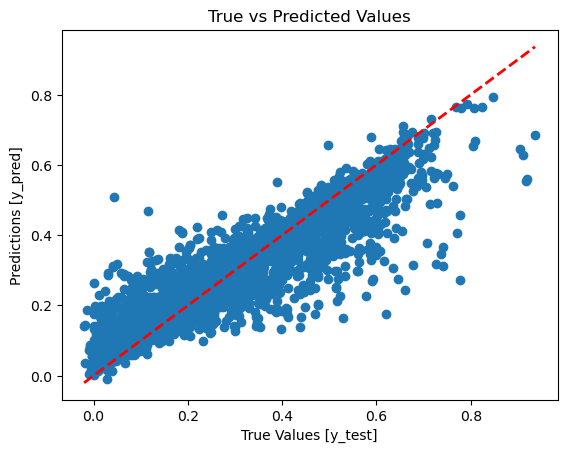

In [19]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

input_array = []
truth_array = []
input_array, truth_array = prepare_data()
input_array = np.concatenate(input_array, axis=0)
truth_array = np.array(truth_array)/100

# Find indices where NaNs are present in input_array and truth_array
nan_indices_input = np.where(np.isnan(input_array).any(axis=(1, 2)))[0]
nan_indices_truth = np.where(np.isnan(truth_array))[0]

# Combine the indices
nan_indices = np.union1d(nan_indices_input, nan_indices_truth)

# Filter out rows with NaNs in both arrays
input_array_filtered = np.delete(input_array, nan_indices, axis=0)
truth_array_filtered = np.delete(truth_array, nan_indices)

print(f"Original input_array shape: {input_array.shape}")
print(f"Filtered input_array shape: {input_array_filtered.shape}")
print(f"Original truth_array shape: {truth_array.shape}")
print(f"Filtered truth_array shape: {truth_array_filtered.shape}")

# featrue format[1-47]: 1: SASA, 2-6: HDMD,  7-15:ss one-hot, 16:rigidity,   17-46: HHblits, 47: log_time
x = input_array_filtered.reshape(input_array_filtered.shape[0], -1, input_array_filtered.shape[1])
#indices = list(range(1, 47))
#x= np.delete(x, indices, axis=-1)
print(x.shape)
y = truth_array_filtered

x = x + 1e-10

np.save('/Users/liyao/Desktop/Tsuda_Lab/Source_code/AI-HDX-main/HDX_MS_dataset/database_collection/feature/x.npy', x)
np.save('/Users/liyao/Desktop/Tsuda_Lab/Source_code/AI-HDX-main/HDX_MS_dataset/database_collection/feature/y.npy', y)

x = np.mean(x, axis=2)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

print('training x:', x_train.shape)
print('training y:', y_train.shape)
print('test x:', x_test.shape)
print('test y:',y_test.shape)

try:
# Initialize the Random Forest Regressor
    random_forest_model = RandomForestRegressor(n_estimators=100, random_state=50, max_features='sqrt')
    random_forest_model.fit(x_train, y_train)
    y_pred = random_forest_model.predict(x_test)

    print('R2 score:', r2_score(y_test, y_pred))
    print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))
    print('Pearson:', pearsonr(y_test, y_pred))

    plt.scatter(y_test, y_pred)
    plt.xlabel('True Values [y_test]')
    plt.ylabel('Predictions [y_pred]')
    plt.title('True vs Predicted Values')

    # Optional: add a line representing perfect predictions
    max_value = max(y_test.max(), y_pred.max())
    min_value = min(y_test.min(), y_pred.min())
    plt.plot([min_value, max_value], [min_value, max_value], color='red', linestyle='--', lw=2)

    plt.show()      
except Exception as e:
    print(e)

In [17]:
from joblib import dump, load

root_dir = "/Users/liyao/Desktop/Tsuda_Lab/Source_code/AI-HDX-main/HDX_MS_dataset/database_collection"
model_path = f"{root_dir}/feature/model_files/RF_240123.joblib"
dump(random_forest_model, model_path)

['/Users/liyao/Desktop/Tsuda_Lab/Source_code/AI-HDX-main/HDX_MS_dataset/database_collection/feature/model_files/RF_240123.joblib']

In [23]:
from scipy.stats import pearsonr

prediction_fpath = '/Users/liyao/Desktop/Tsuda_Lab/Source_code/AI-HDX-main/HDX_MS_dataset/database_collection/feature/CSN3-CSN8/CSN3_prediction.xlsx'
prediction_df = pd.read_excel(prediction_fpath, sheet_name='Sheet1')

print(prediction_df.shape)
truth = prediction_df['%d'].to_numpy()
R2_score_list = []

for col in prediction_df.columns:
    if col == '%d':
        continue
    prediction = prediction_df[col].to_numpy()
    R2_score = pearsonr(truth, prediction)

    R2_score_list.append((col, R2_score))

R2_score_list.sort(key=lambda x: x[1], reverse=True)
for item in R2_score_list:
    print(item[0], item[1])

(342, 101)
model_59_revised PearsonRResult(statistic=0.11710001862527293, pvalue=0.030381218771240035)
model_32_revised PearsonRResult(statistic=0.11466627788962347, pvalue=0.034024252541644505)
model_42_revised PearsonRResult(statistic=0.0762924914570615, pvalue=0.15919547284416025)
model_37_revised PearsonRResult(statistic=0.0755491186464324, pvalue=0.16330976613804685)
model_54_revised PearsonRResult(statistic=0.07478363115069182, pvalue=0.1676293384203447)
model_24_revised PearsonRResult(statistic=0.06787352452032239, pvalue=0.2105515208957488)
model_51_revised PearsonRResult(statistic=0.061149306928767, pvalue=0.2594194328045567)
model_87_revised PearsonRResult(statistic=0.060786619607884854, pvalue=0.2622610501693697)
model_90_revised PearsonRResult(statistic=0.05608670657020055, pvalue=0.3010230795969867)
model_76_revised PearsonRResult(statistic=0.05592509996449639, pvalue=0.3024202192986834)
model_81_revised PearsonRResult(statistic=0.05353293449033955, pvalue=0.32360295454359